# Interoperability with `scirpy`

It is now possible to convert the file formats between `dandelion>=0.1.1` and `scirpy>=0.6.2` [[Sturm2020]](https://academic.oup.com/bioinformatics/article/36/18/4817/5866543) to enhance the collaboration between the analysis toolkits.

<b>Import dandelion module</b>

In [1]:
import os

import dandelion as ddl

# new function to setup tutorial data
from dandelion.tutorial import setup_dandelion_tutorial_tcr

setup_dandelion_tutorial_tcr()

# change to tutorial directory
os.chdir("dandelion_tutorial/")

ddl.logging.print_versions()

dandelion==0.5.7.dev226 pandas==2.2.3 numpy==2.1.3 matplotlib==3.10.1 networkx==3.4.2 scipy==1.15.2


In [2]:
import scirpy as ir
import scanpy as sc


ir.__version__

'0.22.1.dev1+gb32fd24de.d20251104'

## `dandelion`

In [3]:
# read in the airr_rearrangement.tsv file
file_location = "sc5p_v2_hs_PBMC_10k_t/airr_rearrangement.tsv"

# read in gene expression data
adata = sc.read_10x_h5("sc5p_v2_hs_PBMC_10k_t/filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
adata

/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 10553 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

In [4]:
vdj = ddl.read_10x_airr(file_location)
vdj

Dandelion class object with n_obs = 5351 and n_contigs = 10860
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'umi_count', 'is_cell', 'locus', 'rearrangement_status'
    metadata: 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'umi_count_abT_VDJ', '

The test file contains a blank `clone_id` column so we run `find_clones` to populate it first.

In [5]:
ddl.tl.find_clones(vdj)

Finding clones based on abT cell VDJ chains using junction: 100%|██████████| 512/512 [00:00<00:00, 4417.25it/s]
Finding clones based on abT cell VJ chains using junction: 100%|██████████| 1574/1574 [00:00<00:00, 13041.46it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 5351/5351 [00:00<00:00, 486057.84it/s]


In [6]:
# we also generate the network so that this can be passed to scirpy
ddl.tl.generate_network(vdj, key="sequence_alignment")
vdj

Setting up data: 10860it [00:00, 19164.72it/s]
Linking edges : 100%|██████████| 5243/5243 [00:11<00:00, 455.77it/s] 


Dandelion class object with n_obs = 5351 and n_contigs = 10860
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'umi_count', 'is_cell', 'locus', 'rearrangement_status', 'clone_id'
    metadata: 'clone_id', 'clone_id_rank', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'productive_abT_VDJ', 'p

### `ddl.to_scirpy` : Converting `dandelion` to `scirpy`

The `Dandelion` object can be converted to an object compatible with `scirpy` using the `ddl.to_scirpy` function. This is even when there is no original gene expression data available.

In [7]:
# conversion to default scirpy MuData object
irdata = ddl.tl.to_scirpy(vdj)
irdata

/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/utils.py:362: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use n

MuData object with n_obs × n_vars = 5351 × 0
  1 modality
    airr:	5351 x 0
      obsm:	'airr'

Conversion to `AnnData` in scirpy format is also available

In [8]:
converted_adata = ddl.tl.to_scirpy(vdj, to_mudata=False)
converted_adata

AnnData object with n_obs × n_vars = 5351 × 0
    obsm: 'airr'

If you have gene expression data, the parameter `gex_adata` supports the gene expression data in `AnnData` format.

Please note that this will slice to the same cell_id that are present in the same in the AIRR data.

In [9]:
irdata = ddl.tl.to_scirpy(vdj, to_mudata=False, gex_adata=adata)
irdata

AnnData object with n_obs × n_vars = 5333 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
    uns: 'clone_id'
    obsm: 'airr'

In [10]:
mudata = ddl.tl.to_scirpy(vdj, to_mudata=True, gex_adata=adata)
mudata

/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.


MuData object with n_obs × n_vars = 10553 × 36601
  2 modalities
    gex:	10553 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
    airr:	5333 x 0
      uns:	'clone_id'
      obsm:	'airr'

Use scirpy's get functions to retrieve the relevant airr info (https://scirpy.scverse.org/en/latest/generated/scirpy.get.airr.html)

In [11]:
ir.get.airr(irdata, "clone_id")

,VJ_1_clone_id,VDJ_1_clone_id,VJ_2_clone_id,VDJ_2_clone_id
AAACCTGAGCGATAGC-1,abT_VDJ_369_5_6_VJ_127_2_3,abT_VDJ_369_5_6_VJ_127_2_3,None,None
AAACCTGAGTCACGCC-1,abT_VDJ_265_1_1_VJ_1300_1_2,abT_VDJ_265_1_1_VJ_1300_1_2,None,None
AAACCTGCACGTCAGC-1,abT_VDJ_265_3_1_VJ_521_2_29,abT_VDJ_265_3_1_VJ_521_2_29,None,None
AAACCTGGTCAATACC-1,abT_VDJ_374_3_1_VJ_1283_2_1,abT_VDJ_374_3_1_VJ_1283_2_1,None,None
AAACCTGGTTCGGCAC-1,abT_VDJ_83_3_4_VJ_1003_2_1|abT_VDJ_83_3_4_VJ_1...,abT_VDJ_83_3_4_VJ_1003_2_1|abT_VDJ_83_3_4_VJ_1...,abT_VDJ_83_3_4_VJ_1003_2_1|abT_VDJ_83_3_4_VJ_1...,None
...,...,...,...,...
TTTGTCATCGCCGTGA-1,abT_VDJ_250_1_2_VJ_1402_2_1,abT_VDJ_250_1_2_VJ_1402_2_1,None,None
TTTGTCATCGTCTGAA-1,abT_VDJ_6_3_1_VJ_999_1_1,abT_VDJ_6_3_1_VJ_999_1_1,None,None
TTTGTCATCTACCAGA-1,abT_VDJ_231_2_1_VJ_121_2_1,abT_VDJ_231_2_1_VJ_121_2_1,None,None
TTTGTCATCTCTGAGA-1,abT_VDJ_249_5_4_VJ_1483_1_1|abT_VDJ_386_4_1_VJ...,abT_VDJ_249_5_4_VJ_1483_1_1|abT_VDJ_386_4_1_VJ...,None,abT_VDJ_249_5_4_VJ_1483_1_1|abT_VDJ_386_4_1_VJ...


In [12]:
ir.get.airr(mudata, "clone_id")

,VJ_1_clone_id,VDJ_1_clone_id,VJ_2_clone_id,VDJ_2_clone_id
cell_id,,,,
AAACCTGAGCGATAGC-1,abT_VDJ_369_5_6_VJ_127_2_3,abT_VDJ_369_5_6_VJ_127_2_3,None,None
AAACCTGAGTCACGCC-1,abT_VDJ_265_1_1_VJ_1300_1_2,abT_VDJ_265_1_1_VJ_1300_1_2,None,None
AAACCTGCACGTCAGC-1,abT_VDJ_265_3_1_VJ_521_2_29,abT_VDJ_265_3_1_VJ_521_2_29,None,None
AAACCTGGTCAATACC-1,abT_VDJ_374_3_1_VJ_1283_2_1,abT_VDJ_374_3_1_VJ_1283_2_1,None,None
AAACCTGGTTCGGCAC-1,abT_VDJ_83_3_4_VJ_1003_2_1|abT_VDJ_83_3_4_VJ_1...,abT_VDJ_83_3_4_VJ_1003_2_1|abT_VDJ_83_3_4_VJ_1...,abT_VDJ_83_3_4_VJ_1003_2_1|abT_VDJ_83_3_4_VJ_1...,None
...,...,...,...,...
TTTGTCATCGCCGTGA-1,abT_VDJ_250_1_2_VJ_1402_2_1,abT_VDJ_250_1_2_VJ_1402_2_1,None,None
TTTGTCATCGTCTGAA-1,abT_VDJ_6_3_1_VJ_999_1_1,abT_VDJ_6_3_1_VJ_999_1_1,None,None
TTTGTCATCTACCAGA-1,abT_VDJ_231_2_1_VJ_121_2_1,abT_VDJ_231_2_1_VJ_121_2_1,None,None


Or you can add `transfer = True`, which will perform dandelion's `tl.transfer`.

In [13]:
irdatax = ddl.tl.to_scirpy(vdj, transfer=True)
irdatax

/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.


MuData object with n_obs × n_vars = 5351 × 0
  1 modality
    airr:	5351 x 0
      obs:	'clone_id', 'clone_id_rank', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'umi_count_abT_VDJ', 'umi_count_abT_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_abT_VDJ_main', 'd_call_abT_VDJ_main', 'j_call_abT_VDJ_main', 'v_call_abT_VJ_main', 'j_call_abT_VJ_main', 'isotype', 'isotype_status', 'locus_status', 'chain_status', 'rearrangement_status_VDJ', 'rearrangement_status_VJ'
      uns:	'neighbors', 'clone_id'
      obsm:	'airr', 'X_vdj_all', 'X_vdj_expanded', 'X_vdj'
      obsp:	'connectivities', 'distances', 'vdj_connectivities_all', 'vdj_distances_all', 'vdj_connectivities_expanded', 'vdj_distances_expanded', 'vdj_connectivities_full', 'vdj_distances_full'

In [14]:
irdatax = ddl.tl.to_scirpy(vdj, transfer=True, to_mudata=False)
irdatax

AnnData object with n_obs × n_vars = 5351 × 0
    obs: 'clone_id', 'clone_id_rank', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'umi_count_abT_VDJ', 'umi_count_abT_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_abT_VDJ_main', 'd_call_abT_VDJ_main', 'j_call_abT_VDJ_main', 'v_call_abT_VJ_main', 'j_call_abT_VJ_main', 'isotype', 'isotype_status', 'locus_status', 'chain_status', 'rearrangement_status_VDJ', 'rearrangement_status_VJ'
    uns: 'neighbors', 'clone_id'
    obsm: 'airr', 'X_vdj_all', 'X_vdj_expanded', 'X_vdj'
    obsp: 'connectivities', 'distances

### `ddl.from_scirpy` : Converting `scirpy` to `dandelion`

Converting `MuData` back to `Dandelion`

In [15]:
vdjx = ddl.tl.from_scirpy(mudata)
vdjx

Dandelion class object with n_obs = 5333 and n_contigs = 10836
    data: 'c_call', 'c_cigar', 'c_sequence_end', 'c_sequence_start', 'clone_id', 'consensus_count', 'd_call', 'd_cigar', 'd_sequence_end', 'd_sequence_start', 'germline_alignment', 'is_cell', 'j_call', 'j_cigar', 'j_sequence_end', 'j_sequence_start', 'junction', 'junction_aa', 'junction_aa_length', 'junction_length', 'locus', 'productive', 'rearrangement_status', 'rev_comp', 'sequence', 'sequence_aa', 'sequence_alignment', 'sequence_id', 'umi_count', 'v_call', 'v_cigar', 'v_sequence_end', 'v_sequence_start', 'cell_id', 'clone_id_rank', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'umi_count_abT_VDJ', 'umi_count_abT_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_cal

Converting `AnnData` back to `Dandelion`

In [16]:
vdjx = ddl.tl.from_scirpy(irdata)
vdjx

Dandelion class object with n_obs = 5333 and n_contigs = 10836
    data: 'c_call', 'c_cigar', 'c_sequence_end', 'c_sequence_start', 'clone_id', 'consensus_count', 'd_call', 'd_cigar', 'd_sequence_end', 'd_sequence_start', 'germline_alignment', 'is_cell', 'j_call', 'j_cigar', 'j_sequence_end', 'j_sequence_start', 'junction', 'junction_aa', 'junction_aa_length', 'junction_length', 'locus', 'productive', 'rearrangement_status', 'rev_comp', 'sequence', 'sequence_aa', 'sequence_alignment', 'sequence_id', 'umi_count', 'v_call', 'v_cigar', 'v_sequence_end', 'v_sequence_start', 'cell_id', 'clone_id_rank', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'umi_count_abT_VDJ', 'umi_count_abT_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_cal

In [17]:
vdjx.metadata

,clone_id,clone_id_rank,locus_VDJ,locus_VJ,productive_VDJ,productive_VJ,v_call_VDJ,d_call_VDJ,j_call_VDJ,v_call_VJ,...,d_call_abT_VDJ_main,j_call_abT_VDJ_main,v_call_abT_VJ_main,j_call_abT_VJ_main,isotype,isotype_status,locus_status,chain_status,rearrangement_status_VDJ,rearrangement_status_VJ
AAACCTGAGCGATAGC-1,abT_VDJ_369_5_6_VJ_127_2_3,1556,TRB,TRA,True,True,TRBV6-5,None,TRBJ2-3,TRAV23/DV6,...,None,TRBJ2-3,TRAV23/DV6,TRAJ22,None,None,TRB + TRA,Single pair,standard,standard
AAACCTGAGTCACGCC-1,abT_VDJ_265_1_1_VJ_1300_1_2,5052,TRB,TRA,True,True,TRBV6-2,None,TRBJ2-6,TRAV8-6,...,None,TRBJ2-6,TRAV8-6,TRAJ8,None,None,TRB + TRA,Single pair,standard,standard
AAACCTGCACGTCAGC-1,abT_VDJ_265_3_1_VJ_521_2_29,4079,TRB,TRA,True,True,TRBV6-2,None,TRBJ2-6,TRAV1-2,...,None,TRBJ2-6,TRAV1-2,TRAJ33,None,None,TRB + TRA,Single pair,standard,standard
AAACCTGGTCAATACC-1,abT_VDJ_374_3_1_VJ_1283_2_1,4078,TRB,TRA,True,True,TRBV12-4,None,TRBJ2-7,TRAV22,...,None,TRBJ2-7,TRAV22,TRAJ4,None,None,TRB + TRA,Single pair,standard,standard
AAACCTGGTTCGGCAC-1,abT_VDJ_83_3_4_VJ_1003_2_1|abT_VDJ_83_3_4_VJ_1...,4077|4076,TRB,TRA|TRA,True,True|True,TRBV20-1,None,TRBJ1-1,TRAV8-3|TRAV8-2,...,None,TRBJ1-1,TRAV8-3,TRAJ21,None,Multi,TRB + Extra VJ,Extra pair,standard,standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCGCCGTGA-1,abT_VDJ_250_1_2_VJ_1402_2_1,2061,TRB,TRA,True,True,TRBV12-4,None,TRBJ2-3,TRAV8-2,...,None,TRBJ2-3,TRAV8-2,TRAJ13,None,None,TRB + TRA,Single pair,standard,standard
TTTGTCATCGTCTGAA-1,abT_VDJ_6_3_1_VJ_999_1_1,2060,TRB,TRA,True,True,TRBV7-8,None,TRBJ1-3,TRAV8-6,...,None,TRBJ1-3,TRAV8-6,TRAJ27,None,None,TRB + TRA,Single pair,standard,standard
TTTGTCATCTACCAGA-1,abT_VDJ_231_2_1_VJ_121_2_1,2059,TRB,TRA,True,True,TRBV6-6,TRBD1,TRBJ2-3,TRAV8-6,...,TRBD1,TRBJ2-3,TRAV8-6,TRAJ48,None,None,TRB + TRA,Single pair,standard,standard
TTTGTCATCTCTGAGA-1,abT_VDJ_249_5_4_VJ_1483_1_1|abT_VDJ_386_4_1_VJ...,2058|2057,TRB|TRB,TRA,True|True,True,TRBV7-2|TRBV11-2,None,TRBJ1-2|TRBJ1-4,TRAV3,...,None,TRBJ1-2,TRAV3,TRAJ22,None|None,Multi,Extra VDJ + TRA,Extra pair,standard,standard


This time, find clones with `scirpy`'s method.

In [18]:
ir.tl.chain_qc(irdata)
ir.pp.ir_dist(irdata)
ir.tl.define_clonotypes(irdata, receptor_arms="all", dual_ir="primary_only")
irdata

AnnData object with n_obs × n_vars = 5333 × 36601
    obs: 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
    uns: 'clone_id', 'chain_indices', 'ir_dist_nt_identity'
    obsm: 'airr', 'chain_indices'

### Visualising with `scirpy`'s plotting tools

You can now also plot `dandelion` networks using `scirpy`'s functions.

In [19]:
irdata = ddl.tl.to_scirpy(vdj, to_mudata=True, gex_adata=adata)
irdata

/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.


MuData object with n_obs × n_vars = 10553 × 36601
  2 modalities
    gex:	10553 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
    airr:	5333 x 0
      uns:	'clone_id'
      obsm:	'airr'

In [20]:
ddl.tl.transfer(irdata, vdj, overwrite=True)
irdata

MuData object with n_obs × n_vars = 10553 × 36601
  2 modalities
    gex:	10553 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
    airr:	5333 x 0
      obs:	'clone_id', 'clone_id_rank', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'umi_count_abT_VDJ', 'umi_count_abT_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_abT_VDJ_main', 'd_call_abT_VDJ_main', 'j_call_abT_VDJ_main', 'v_call_abT_VJ_main', 'j_call_abT_VJ_main', 'isotype', 'isotype_status', 'locus_status', 'chain_status', 'rearrangement_status_VDJ', 'rearrangement_status_VJ'
      uns:	'clone_id', 'neighbors'
      obsm:	'airr', 'X_vdj_all', 'X_vdj_expanded', 'X_vdj'
      obsp:	'connectivities', 'distances', 'vdj_connectivities_all', 'vdj_distances_all', 'vdj_connectivities_expanded', 'vdj_distances_expanded', 'vdj_connectivities_full', 'vdj_distances_full'

In [21]:
ddl.tl.transfer(
    irdata, vdj, overwrite=True
)  # overwrite scirpy's clone_id definition

/Users/uqztuong/Documents/GitHub/scirpy/src/scirpy/pl/_clonotypes.py:179: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.


<Axes: >

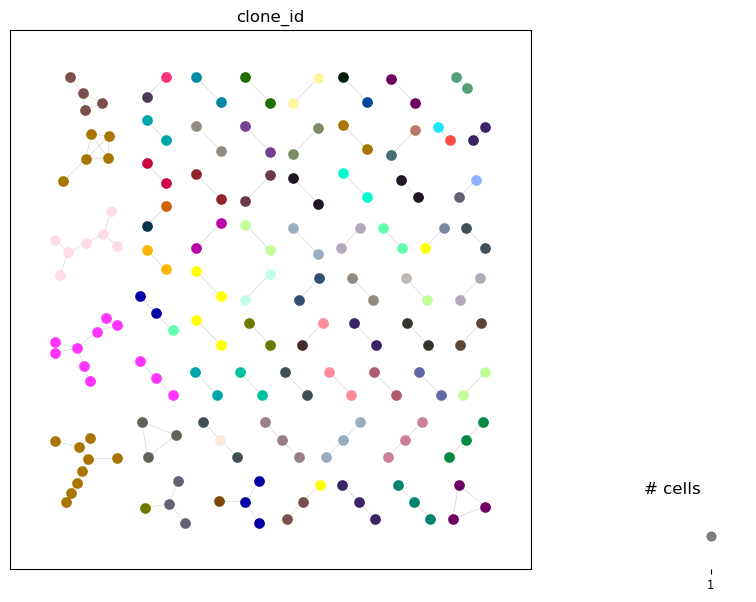

In [22]:
ir.tl.clonotype_network(irdata, min_cells=2)
ir.pl.clonotype_network(
    irdata, color="clone_id", panel_size=(7, 7), show_labels=False
)  # hiding labels because they clutter the plot

We can also use a shorter `clone_id` name ordered by size, called `clone_id_rank`.

/Users/uqztuong/Documents/GitHub/scirpy/src/scirpy/pl/_clonotypes.py:179: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.


<Axes: >

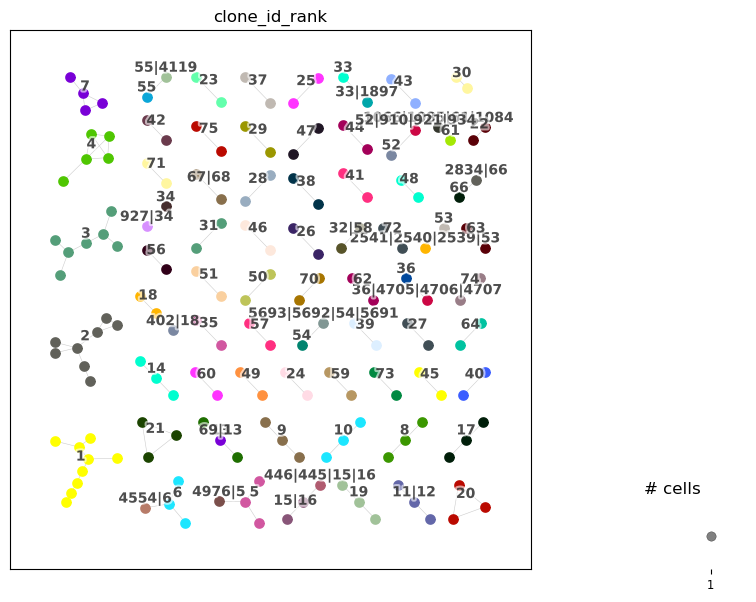

In [23]:
ddl.tl.transfer(irdata, vdj, clone_key="clone_id_rank")
ir.tl.clonotype_network(irdata, clonotype_key="clone_id_rank", min_cells=2)
ir.pl.clonotype_network(irdata, color="clone_id_rank", panel_size=(7, 7))

you can also collapse the networks to a single node and plot by size

/Users/uqztuong/Documents/GitHub/scirpy/src/scirpy/pl/_clonotypes.py:179: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.


<Axes: >

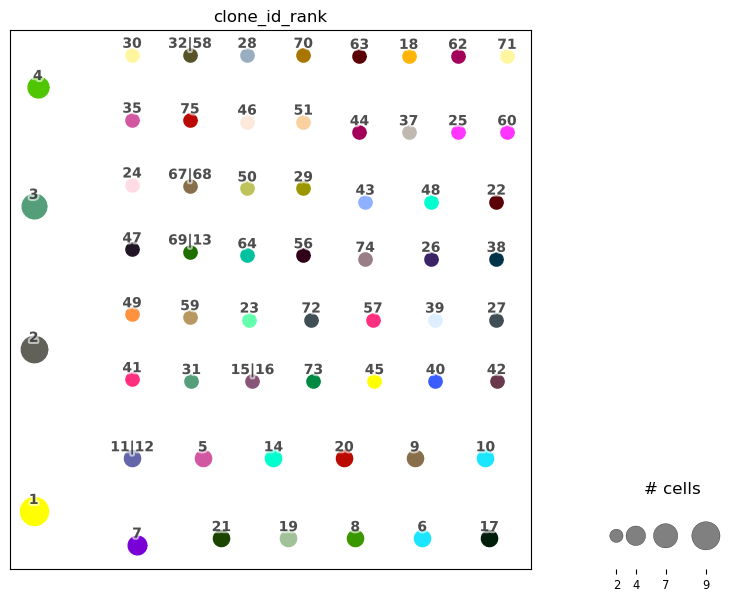

In [24]:
ddl.tl.transfer(irdata, vdj, clone_key="clone_id_rank", collapse_nodes=True)
ir.tl.clonotype_network(irdata, clonotype_key="clone_id_rank", min_cells=2)
ir.pl.clonotype_network(irdata, color="clone_id_rank", panel_size=(7, 7))

## Using `ddl.pl.clone_network` on `MuData` with `scirpy` data

Now that we have created a `MuData` object with `scirpy` data, we can also use `dandelion`'s plotting function to visualise the clone networks. The way to access the column in the `obs` of the `MuData` object is to prefix the observation key with the modality name, for example `gex:{column name}`. If the columns are in the VDJ modality, you can use `vdj:{column name}`. Or if the column is in the shared `obs` i.e. `MuData.obs`, you can use just the column name.

In [25]:
# create random 3 categorical variable in gex obs for testing
import numpy as np
import pandas as pd

# create random 3 categorical variable in gex obs for testing
irdata.mod["gex"].obs["new_category"] = pd.Categorical(
    np.random.choice(["A", "B", "C"], size=irdata.mod["gex"].n_obs)
)
# also create in the shared obs
irdata.obs["shared_category"] = pd.Categorical(
    np.random.choice(["D", "E", "F"], size=irdata.n_obs)
)
irdata

MuData object with n_obs × n_vars = 10553 × 36601
  obs:	'shared_category'
  2 modalities
    gex:	10553 x 36601
      obs:	'new_category'
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
    airr:	5333 x 0
      obs:	'clone_id', 'clone_id_rank', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'umi_count_abT_VDJ', 'umi_count_abT_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_abT_VDJ_main', 'd_call_abT_VDJ_main', 'j_call_abT_VDJ_main', 'v_call_abT_VJ_main', 'j_call_abT_VJ_main', 'isotype', 'isotype_status', 'locus_status', 'chain_status', 'rearrangement_status_VDJ', 'rearrangement_status_VJ'
      uns:	'clone_id', 'neighbors', 'gex_neighbors', 'clonotype_network', 'clone_id_colors', 'clone_id_rank', 'clone_id_rank_colors'
      obsm:	'airr', 'X_vdj_all', 'X_vdj_expanded', 'X_vdj', 'X_clonotype_network'
      obsp:	'connectivities', 'distances', 'vdj_connectivities_all', 'vdj_distances_all', 'vdj_connectivities_expanded', 'vdj_distances_expanded', 'vdj_connectivities_full', 'vdj_distances_full', 'gex_connectivities', 'gex_distances'

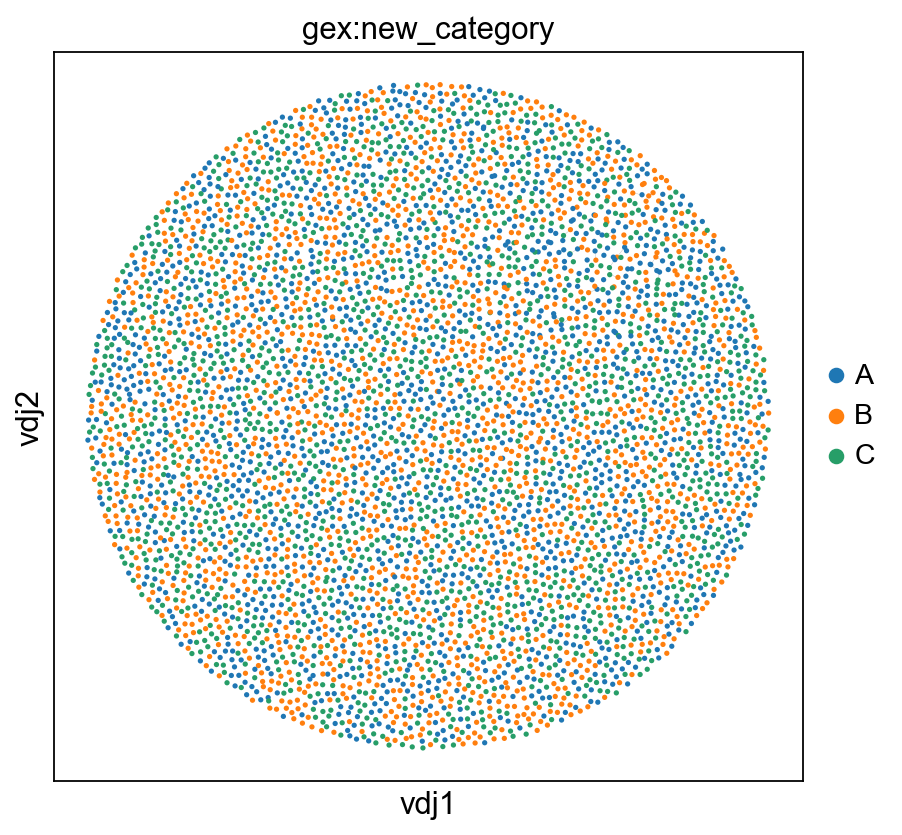

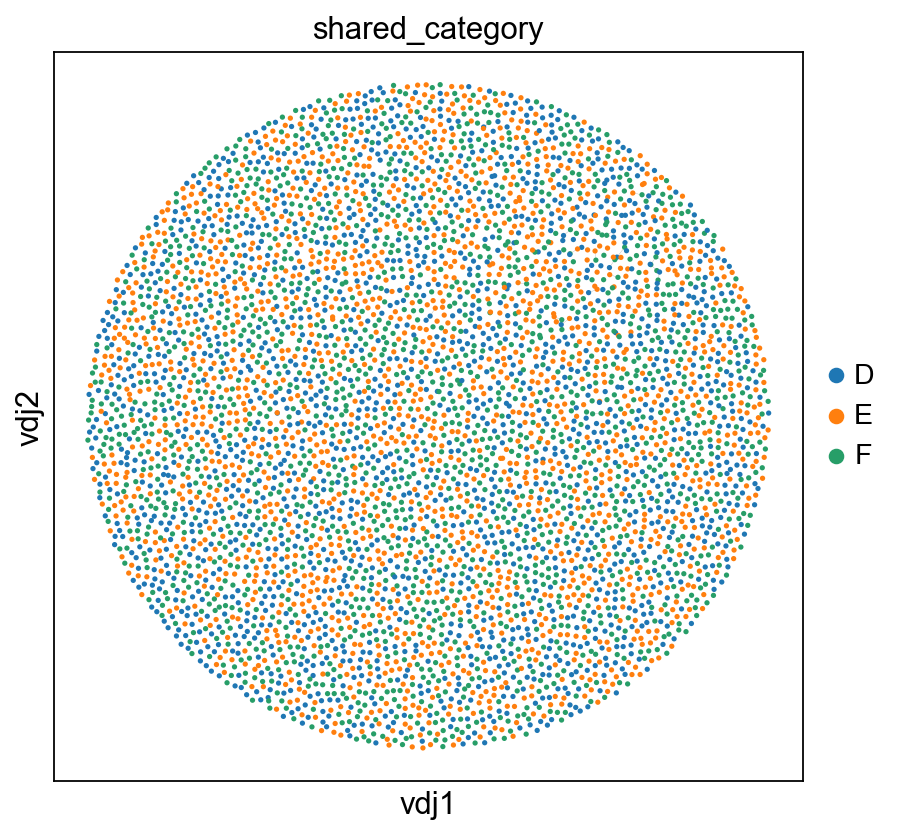

In [26]:
sc.set_figure_params(figsize=(6, 6))
ddl.pl.clone_network(irdata, color="gex:new_category")
ddl.pl.clone_network(irdata, color="shared_category")